In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
def load_mnist(batch_size=64):
    """Load MNIST dataset with standard train/val/test split"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_data, val_data = random_split(full_train, [train_size, val_size])

    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_mnist(batch_size=64)

In [22]:
class FCNN(nn.Module):
    """Fully Connected Neural Network for MNIST classification"""
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [15]:
class CNN(nn.Module):
    """Convolutional Neural Network for MNIST classification"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [16]:
def train(model, device, train_loader, optimizer, epoch):
    """Train the model for one epoch"""
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

def validate(model, device, val_loader):
    """Evaluate the model on validation set"""
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

def test(model, device, test_loader):
    """Evaluate the model on test set"""
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

def train_model(model, device, train_loader, val_loader, epochs=10, lr=0.001):
    """Train and validate the model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
        val_loss, val_acc = validate(model, device, val_loader)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

def plot_metrics(train_losses, val_losses, train_accs, val_accs, model_name):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.legend()

    plt.show()

Training Fully Connected Neural Network...
Epoch 1: Train Loss: 0.0046, Val Loss: 0.1534, Train Acc: 90.95%, Val Acc: 95.38%
Epoch 2: Train Loss: 0.0022, Val Loss: 0.1100, Train Acc: 95.92%, Val Acc: 96.67%
Epoch 3: Train Loss: 0.0016, Val Loss: 0.1026, Train Acc: 96.96%, Val Acc: 96.95%
Epoch 4: Train Loss: 0.0014, Val Loss: 0.0983, Train Acc: 97.30%, Val Acc: 97.16%
Epoch 5: Train Loss: 0.0012, Val Loss: 0.0901, Train Acc: 97.74%, Val Acc: 97.38%
Epoch 6: Train Loss: 0.0011, Val Loss: 0.0996, Train Acc: 97.87%, Val Acc: 97.28%
Epoch 7: Train Loss: 0.0009, Val Loss: 0.0920, Train Acc: 98.26%, Val Acc: 97.67%
Epoch 8: Train Loss: 0.0008, Val Loss: 0.0914, Train Acc: 98.45%, Val Acc: 97.63%
Epoch 9: Train Loss: 0.0005, Val Loss: 0.0773, Train Acc: 99.12%, Val Acc: 98.05%
Epoch 10: Train Loss: 0.0003, Val Loss: 0.0763, Train Acc: 99.40%, Val Acc: 98.08%
Epoch 11: Train Loss: 0.0002, Val Loss: 0.0783, Train Acc: 99.49%, Val Acc: 98.17%
Epoch 12: Train Loss: 0.0002, Val Loss: 0.0804, Train

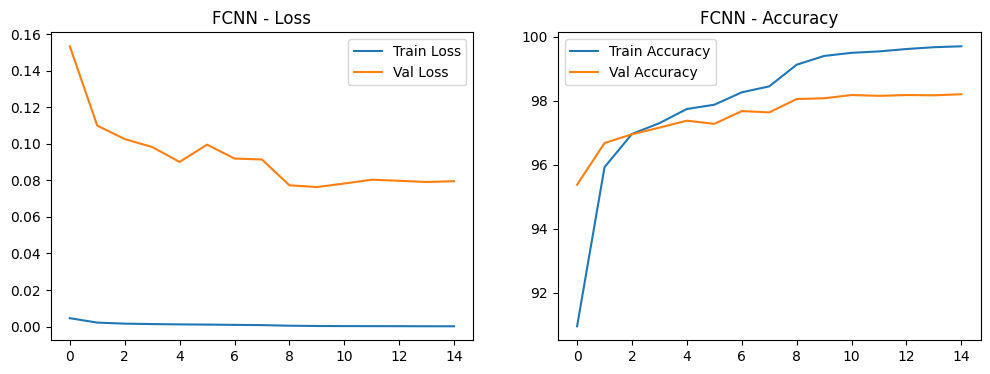

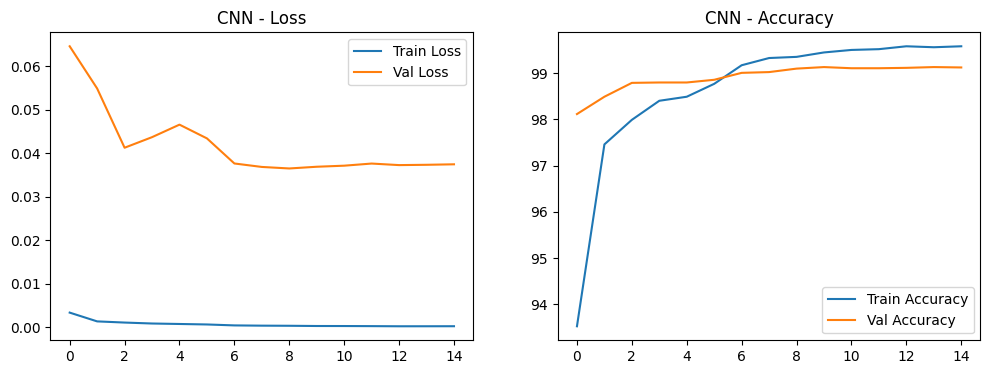


Testing Fully Connected Neural Network...

Test set: Average loss: 0.0712, Accuracy: 9840/10000 (98.40%)


Testing Convolutional Neural Network...

Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)



In [6]:
fcnn = FCNN().to(device)
cnn = CNN().to(device)

print("Training Fully Connected Neural Network...")
fcnn_train_losses, fcnn_val_losses, fcnn_train_accs, fcnn_val_accs = train_model(
    fcnn, device, train_loader, val_loader, epochs=15, lr=0.001
)

print("\nTraining Convolutional Neural Network...")
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(
    cnn, device, train_loader, val_loader, epochs=15, lr=0.001
)

plot_metrics(fcnn_train_losses, fcnn_val_losses, fcnn_train_accs, fcnn_val_accs, "FCNN")
plot_metrics(cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs, "CNN")

print("\nTesting Fully Connected Neural Network...")
fcnn_test_loss, fcnn_test_acc = test(fcnn, device, test_loader)

print("\nTesting Convolutional Neural Network...")
cnn_test_loss, cnn_test_acc = test(cnn, device, test_loader)

In [17]:
def predict_digit(model, image_path , device):
    """Predict digit from a handwritten image with proper MNIST formatting"""
    from PIL import Image
    import numpy as np

    image = Image.open(image_path).convert('L')

    img_array = np.array(image)

    if img_array.mean() > 128:
        img_array = 255 - img_array

    image = Image.fromarray(img_array)
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1, keepdim=True)

    return pred.item()

In [18]:
torch.save(cnn.state_dict(), 'mnist_cnn.pth')

In [19]:
def load_and_predict(image_path):
    model = CNN().to(device)
    model.load_state_dict(torch.load('mnist_cnn.pth', map_location=device))
    model.eval()

    digit = predict_digit(model, image_path, device)
    print(f"Predicted digit: {digit}")

In [21]:
load_and_predict('5.jpg')

Predicted digit: 5
